### **Rendering component declaration.**

In [1]:
# imports for setting up display for the colab server.
!sudo apt-get update  > /dev/null 2>&1
!sudo apt-get install -y xvfb x11-utils  > /dev/null 2>&1
!pip install gym==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*  > /dev/null 2>&1

In [2]:
# gym related import statements.
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
# RL agent construction related imports.
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.special import softmax
# virtual display related import statements.
import math
import glob
import io
import base64
import time
from time import sleep
from tqdm import tqdm
from IPython.display import HTML
from IPython import display as ipythondisplay

In [3]:
# This creates virtual display to send the frames for being rendered.
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1366, 768))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1366x768x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1366x768x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
def show_video():
    '''
    This function loads the data video inline into the colab notebook.
    By reading the video stored by the Monitor class.
    '''
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    '''
    This monitoring tool records the outputs from the output and saves it a
    mp4 file in the stated directory. If we don't change the video directory
    the videos will get stored in 'content/' directory.
    '''
    env = Monitor(env, './video', force=True)
    return env

### **SARSA(Lambda) Algorithm Implementation for MountainCarV0 Environment**

__The implementation consists of below stated sections:__  
* __Agent class decleration and parsing environment.__
* __SARSA(LAMBDA) Algorithm Implementation.__
* __Plotting results, outputting results and downloading them.__

### **Agent Class Decleration and Parsing Environment**

In [5]:
# This environment has two degrees of freedom: position and velocity.
# Our agent will learn to interact with environment having these two values.
class State:
    def __init__(self):
        self.pos = None
        self.vel = None

# Agent class defined for storing all the agent related values.
# and getting actions from the policy. Here, target policy is same as behavior policy.
class Agent:
    def __init__(self, env):
        self.velocity_lim = np.array([env.observation_space.low[1], env.observation_space.high[1]])
        self.position_lim = np.array([env.observation_space.low[0], env.observation_space.high[0]])

        self.velocity_step, self.position_step = 0.005, 0.1
        self.velocity_space = np.arange(self.velocity_lim[0], self.velocity_lim[1] 
                                       + self.velocity_step, self.velocity_step)
        self.position_space = np.arange(self.position_lim[0], self.position_lim[1] 
                                       + self.position_step, self.position_step)
        self.m, self.n, self.n_action = len(self.velocity_space), len(self.position_space), 3
        self.Q_sa = np.full(shape = (self.m, self.n, 3),
                                       fill_value = 0.0, dtype = np.float32)
        self.collective_record = []
        self.success = []
        
    def get_action_value_index(self, state):
        pos_offset = state[0] - self.position_lim[0]
        vel_offset = state[1] - self.velocity_lim[0]
        pos_ind = pos_offset // self.position_step
        vel_ind = vel_offset // self.velocity_step
        
        return np.array([vel_ind, pos_ind], dtype= np.int)
  
    def get_action(self, state):
        ind = self.get_action_value_index(state, 0)
        p = self.Policy[ind[0], ind[1], :]
        action = np.random.choice([0, 1, 2], size = 1, p = p)
        return action[0]

In [6]:
# Wraping the environment in the Monitor class.
env = wrap_env(gym.make('MountainCar-v0'))
# Fixing the randomness in the environment.
env.seed(0)

[0]

In [7]:
# Parsing the environment onto Agent object.
sarsa_agent = Agent(env)
# For some information into Q(s,a) table generated.
# It's dimension is equal to A(Q(s,a)) = n[D(1)]*n[D(2)]*...*n[D(f)]*n(D(actions))
print("Q Shape = ",sarsa_agent.Q_sa.shape)

Q Shape =  (30, 20, 3)


### **SARSA(Lambda) algorithm implementation.**

In [8]:
# SARSA(lambda) algorithm takes part from TD(0) and TD(1) algorithm.

eps = 0.8 # greedy epsilon exploration-vs-exploitation variable.
changed_eps= []
changes_alpha= []
alpha = 0.2 # learning rate value
lambda_val = 0.8 # credit assignment variable to previous states.
alpha_decay = 0.999
eps_decay = 0.995
sarsa_agent.e = np.zeros(shape = (sarsa_agent.m, sarsa_agent.n, 3)) # eligibility of all states.
finish = False
num_iter = 2000
for i_eps in tqdm(range(1, num_iter + 1)):
    state = env.reset()
    sarsa_agent.e[:, :, :] = 0
    gamma = 1.0
    ind = sarsa_agent.get_action_value_index(state)
    # greedy exploration and exploitation step.
    if np.random.random() < 1 - eps:
        action = np.argmax(sarsa_agent.Q_sa[ind[0], ind[1], :]) 
    else:
        action = np.random.randint(0, 3)
    # running episodes for 200 times for this environment.
    for t in range(201):
        ind = sarsa_agent.get_action_value_index(state)
        next_state, reward, done, info = env.step(action)
        next_ind = sarsa_agent.get_action_value_index(next_state)
        
        if np.random.random() < 1 - eps:
            next_action = np.argmax(sarsa_agent.Q_sa[next_ind[0], next_ind[1], :]) 
        else: 
            next_action = np.random.randint(0, 3)
        
        # forward view T(lambda) SARSA equation for making updates.
        delta = reward + gamma * sarsa_agent.Q_sa[next_ind[0],next_ind[1], next_action] - sarsa_agent.Q_sa[ind[0],ind[1],action]
        sarsa_agent.e[ind[0],ind[1],action] += 1
        sarsa_agent.Q_sa = np.add(sarsa_agent.Q_sa, np.multiply(alpha * delta, sarsa_agent.e))
        sarsa_agent.e = np.multiply(gamma * lambda_val, sarsa_agent.e)
        
        if done: 
            if t < 199:
                sarsa_agent.success.append((i_eps, t))
            sarsa_agent.collective_record.append(-t)
            eps = max(0.0, eps * eps_decay)
            alpha = max(0.0, alpha * alpha_decay)
            break
        state = next_state
        action = next_action

100%|██████████| 2000/2000 [00:52<00:00, 37.97it/s] 


### **Plotting reward fuction resuls and displaying output.**

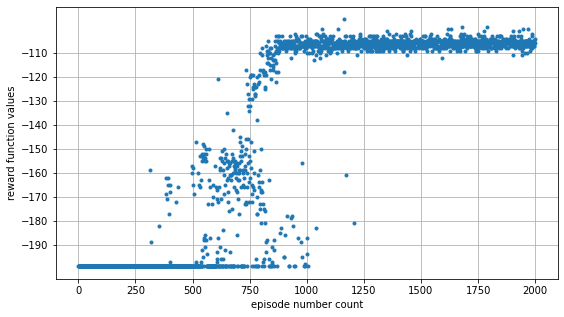

In [9]:
# This graph shows the saturation of rewards to a minimum under 1000 episodes.
fig, ax = plt.subplots(figsize = (9, 5))
plt.plot(sarsa_agent.collective_record[:],'.')
plt.yticks(range(-110, -200, -10))
plt.ylabel("reward function values")
plt.xlabel("episode number count")
plt.grid()
plt.show()

In [10]:
# Calculating the mean performance of the agent.
for i_eps in (range(1, 100)):
    state = env.reset()
    gamma = 1.0
    ind = sarsa_agent.get_action_value_index(state)
    action = np.argmax(sarsa_agent.Q_sa[ind[0], ind[1], :]) 
    
    for t in range(201):
        env.render()
        ind = sarsa_agent.get_action_value_index(state)
        next_state, reward, done, info = env.step(action)
        next_ind = sarsa_agent.get_action_value_index(next_state)
        
        next_action = np.argmax(sarsa_agent.Q_sa[next_ind[0], next_ind[1], :])
        
        if done: 
            if t < 199:
                sarsa_agent.success.append((i_eps, t))
            sarsa_agent.collective_record.append(-t)
            sleep(1)
            break
        state = next_state
        action = next_action
        

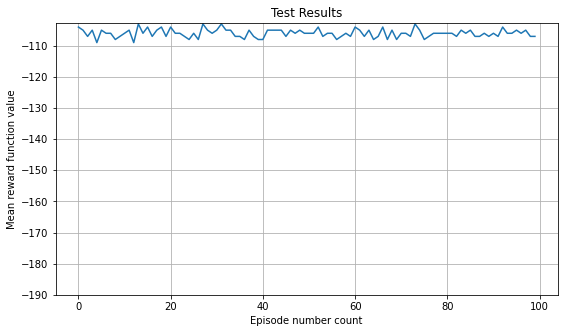

In [11]:
# Plotting the mean performance of the agent.
fig, ax = plt.subplots(figsize = (9, 5))
plt.plot(sarsa_agent.collective_record[-100:], '-')
plt.yticks(range(-110, -200, -10))
plt.title("Test Results")
plt.ylabel("Mean reward function value")
plt.xlabel("Episode number count")
plt.grid()
plt.show()

In [12]:
# Demonstrating the output of the agent's working.
show_video()

In [14]:
# zipping the video folder for the given SARSA agent.
!zip -r /content/file.zip /content/video
# downloading the file resource.
from google.colab import files
files.download("/content/file.zip")

  adding: content/video/ (stored 0%)
  adding: content/video/openaigym.video.0.1649.video000512.meta.json (deflated 60%)
  adding: content/video/openaigym.video.0.1649.video002000.mp4 (deflated 7%)
  adding: content/video/openaigym.video.0.1649.video000001.meta.json (deflated 60%)
  adding: content/video/openaigym.video.0.1649.video000729.meta.json (deflated 60%)
  adding: content/video/openaigym.video.0.1649.video001000.meta.json (deflated 60%)
  adding: content/video/openaigym.video.0.1649.video000512.mp4 (deflated 6%)
  adding: content/video/openaigym.video.0.1649.video001000.mp4 (deflated 7%)
  adding: content/video/openaigym.video.0.1649.video000125.mp4 (deflated 7%)
  adding: content/video/openaigym.video.0.1649.video000008.meta.json (deflated 60%)
  adding: content/video/openaigym.video.0.1649.video000064.mp4 (deflated 9%)
  adding: content/video/openaigym.video.0.1649.video000125.meta.json (deflated 60%)
  adding: content/video/openaigym.video.0.1649.video000000.mp4 (deflated 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>